In [13]:
this_file_name = 'sketching_configuration_mapping.ipynb'
import sys
import os
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname(this_file_name), '../../src/') ))

from configuration_space_mapping import *
from utils import *
import pandas as pd
import matplotlib.pyplot as plt

# Some simulation codes

First, retrieve all scene objects' configuration and position. 

In [14]:
client_id = connect_2_sim()
test_connection(client_id)

Connected to remote API server
Number of objects in the scene:  42


In [15]:
scene_objects = ['Cuboid_0','Cuboid_1','Cuboid_2',
                 'Cuboid_3','Cuboid_4','dr20']

listazinha = get_scene_objects_info(client_id, scene_objects)

for element in listazinha:
    a = round(element['object_position'][0],2)
    b = round(element['object_position'][1],2)
    c = round(element['object_position'][2],2)
    print([a,b,c])

[-1.72, 0.25, 0.25]
[-0.35, 1.5, 0.5]
[-1.52, -1.22, 0.5]
[-0.15, -0.1, 0.25]
[1.4, -0.15, 0.5]
[-2.02, 1.73, 0.15]


In [16]:
info_list, robot_information = split_robot_from_info_list(listazinha,'dr20')

In [17]:
# re orient the robot to test stuff

handle_dr20 = get_object_handle(client_id,'dr20')
euler_orientation = (0,0,1.57)
sim.simxSetObjectOrientation(client_id,handle_dr20,-1,euler_orientation,sim.simx_opmode_blocking)

0

# Trying to create the mapping algorithm: 2nd approach

In [18]:
# Now that I have the objects handlers, I need to get the robot handler so I can retrieve its global coordinates and normals
local_c_robot = get_bounding_box_corners_local_coordinates(client_id, robot_information['object_handler'])

position_robot = robot_information['object_position']
orientation_robot = robot_information['object_orientation']
orientation_robot.reverse() # notice that the orientation vector is reversed (theta is naturally the last, but we need to have it as the first value)

global_coordin_corners_robot = map_local_coordinates_to_global_coordinates(local_c_robot, orientation_robot, position_robot)

normals_robot = get_normals_orientation(robot_information['object_orientation'][2])

# mirroring the normal vectors
negative_delocation = (np.pi,np.pi,np.pi,np.pi)
normals_robot = [sum(x) for x in zip(normals_robot,negative_delocation)]

temporary_normals_robot = []
for normal_robot_element in normals_robot:
    temporary_normals_robot.append(convert_angle_to_0_2pi_interval(normal_robot_element))

normals_robot = temporary_normals_robot

In [19]:
# I need to retrieve the global coordinates and normals of an obstacle. Let's suppose the Cuboid_0 for this test

cuboid_number = 0

local_c_cuboid = get_bounding_box_corners_local_coordinates(client_id, listazinha[cuboid_number]['object_handler'])

orientation_cuboid = listazinha[cuboid_number]['object_orientation']
orientation_cuboid.reverse() # notice that the orientation vector is reversed (theta is naturally the last, but we need to have it as the first value)
position_cuboid = listazinha[cuboid_number]['object_position']

global_coordinates_cuboid = map_local_coordinates_to_global_coordinates(local_c_cuboid, orientation_cuboid, position_cuboid)

normals_cuboid = get_normals_orientation(listazinha[cuboid_number]['object_orientation'][2])

temporary_normals_cuboid = []
for normal_cuboid_element in normals_cuboid:
    temporary_normals_cuboid.append(convert_angle_to_0_2pi_interval(normal_cuboid_element))

normals_cuboid = temporary_normals_cuboid

In [20]:
# I need to check if a given normal is between other two, right? Then I can use a table or something to do so
# How? On one column I gonna put the normals of the robot and of the obstacle.
# On other column I'll indicate the owner of the normal: robot or obstacle
# On the third column I'll indicate the normal order (first normal: right face, second one: up face, etc)
# Now I can order the rows according to the normal order: increasing
# Then I will scan the lines to see if a given normal lies between other two
normal_robot_series = pd.Series(normals_robot, name='normals')
normal_robot_name_series = pd.Series([1,2,3,4], name= 'normal_order')
normal_cuboid_series = pd.Series(normals_cuboid, name='normals')
normal_cuboid_name_series = pd.Series([1,2,3,4], name= 'normal_order')

normals_series = pd.concat([normal_robot_series, normal_cuboid_series], ignore_index=True)
normals_order = pd.concat([normal_robot_name_series, normal_cuboid_name_series], ignore_index=True)

dframe_normals = pd.DataFrame({'normals': normals_series, 'normal_order': normals_order, 'owner':['r','r','r','r','o','o','o','o']})
dframe_normals.sort_values(by='normals', inplace=True)
dframe_normals

,normals,normal_order,owner
7,9.124924e-09,4,o
1,1.985154e-03,2,r
4,1.570796e+00,1,o
2,1.572781e+00,3,r
5,3.141593e+00,2,o
3,3.143578e+00,4,r
6,4.712389e+00,3,o
0,4.714374e+00,1,r


In [21]:
# PAblo showed me my algorith was wrong. Here it goes the algorithm corrected
vertices_list = []
for it in range(0,dframe_normals.shape[0]-1):
    """
    print(f'it = {it}')
    print(dframe_normals.iloc[it-1:it+2,-1])
    print(is_between(dframe_normals.iloc[it-1:it+2,-1].values))
    print(" ")
    """
    #print(dframe_normals.iloc[it,-1])
    #print(dframe_normals.iloc[it+1:,-1])
    next_different = dframe_normals.iloc[it+1:,-1].ne(dframe_normals.iloc[it,-1]).idxmax() 
    current_element = dframe_normals.iloc[it,-1]
    next_diff_element = dframe_normals.iloc[next_different,-1]

    if next_diff_element != current_element:
        if dframe_normals.iloc[it,-1] == 'r':
            a_index = dframe_normals.iloc[it,1]
            b_index = dframe_normals.iloc[next_different,1]
        else:
            a_index = dframe_normals.iloc[next_different,1]
            b_index = dframe_normals.iloc[it,1]    
        new_vertice = global_coordinates_cuboid[b_index-1]-global_coordin_corners_robot[a_index-1]
        vertices_list.append(new_vertice)

if dframe_normals.iloc[0,-1] != dframe_normals.iloc[-1,-1]:
    if dframe_normals.iloc[-1,-1] == 'r':
        a_index = dframe_normals.iloc[-1,1]
        b_index = dframe_normals.iloc[0,1]
    else:
        a_index = dframe_normals.iloc[0,1]
        b_index = dframe_normals.iloc[-1,1]    
    new_vertice = global_coordinates_cuboid[b_index-1]-global_coordin_corners_robot[a_index-1]
    vertices_list.append(new_vertice)

        
    #if next_different != it
  #  print(f'it = {it}, current_element = {current_element} | next_different_index = {next_different}, next_different_element = {next_diff_element}')

In [22]:
v_list_np = np.array(vertices_list)

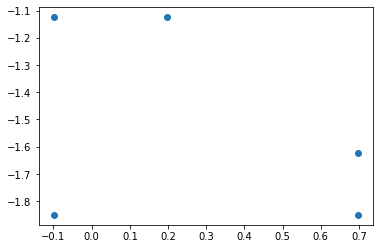

In [23]:
plt.scatter(v_list_np[:,0], v_list_np[:,1])

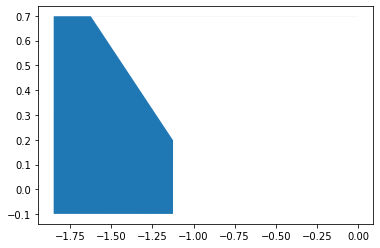

In [24]:
plt.fill_betweenx(v_list_np[:,0],v_list_np[:,1])

# Testing some random ideas and useful functions

In [5]:
for element in info_list:
    print(element['object_name'])

Cuboid_0
Cuboid_1
Cuboid_2
Cuboid_3
Cuboid_4


In [7]:
sim.simxGetObjectOrientation(client_id, handle_dr20,-1, sim.simx_opmode_blocking) # see if orientation is ok

(0, [0.0019730785861611366, 1.8449616618454456e-05, 1.5700498819351196])

In [8]:
robot_pos, robot_ang = get_configuration(client_id, handle_dr20)
180*robot_ang[2]/3.14 # robot orientation in deg

89.99863627609933

In [9]:
get_normals_orientation(0)

(0, 1.570796326795, 3.14159265359, 4.7123889803850005)

In [10]:
for element in info_list:
    normals = get_normals_orientation(element['object_orientation'][2])
    # position_x = round
    print(f'{element["object_name"]}: {normals}')

Cuboid_0: (8.827220187423702e-17, 1.570796326795, 3.14159265359, 4.7123889803850005)
Cuboid_1: (6.891155126999976e-14, 1.5707963267950689, 3.141592653590069, 4.712388980385069)
Cuboid_2: (4.027191677940969e-17, 1.570796326795, 3.14159265359, 4.7123889803850005)
Cuboid_3: (-1.79498325272905e-17, 1.570796326795, 3.14159265359, 4.7123889803850005)
Cuboid_4: (2.288786255621566e-17, 1.570796326795, 3.14159265359, 4.7123889803850005)


In [11]:
x_min, y_min, z_min, x_max, y_max, z_max = get_bounding_box_corners_positions(client_id,listazinha[0]['object_handler'],"model")

In [12]:
# in order to test the map_local_coordinates_to_global_coordinates() power to map the corners local coordinates to global values,
# let's use the cuboid 0. It is global corners must be something like
# [-1.5, 0.5] [-2, 0.5] [-2, 0] [-1.5, 0]

cuboid_number = 0
local_c_cuboid = get_bounding_box_corners_local_coordinates(client_id, listazinha[cuboid_number]['object_handler'])
orientation_cuboid = listazinha[cuboid_number]['object_orientation']
orientation_cuboid.reverse() # notice that the orientation vector is reversed (theta is naturally the last, but we need to have it as the first value)
position_cuboid = listazinha[cuboid_number]['object_position']
global_coordinates_cuboid = map_local_coordinates_to_global_coordinates(local_c_cuboid, orientation_cuboid, position_cuboid)

we know there are 4 horizontal normal vectors. Two of them point to X and Y. The other two point to -X and -Y. 

How to know where X is pointing? Well, it is given by the Z Euler vector. 

Where does Y point to? to X+90º. And what about -X and -Y? We just need to add 180º to X and Y.

# Creating Configuration Map

1. Step
To orient the robot so its euler angles will be 0,0,0.
2. Step
For each obstacle, do the following:
- Get the bounding box vertices from $x_{min}, x_{max}, y_{min}, y_{max}, z_{min}, z_{max}$
- Map bounding box vertices (in object's reference frame to global reference frame)
- Test applicability using the normal's orientation (i think i'll need to check sine and cossine, or limit the orientation within [0,2pi] )
- Create Configuration Vertice 

In [63]:
cuboid_number = 0
orient_cuboid = info_list[cuboid_number]['object_orientation']
n_4_obj, n_1_obj, n_2_obj, n_3_obj = get_normals_orientation(orient_cuboid[2]) 
# notice the numering of the normal vectors

In [64]:
pi = 3.14159265359
orient_robot = robot_information['object_orientation']
n_4_robot, n_1_robot, n_2_robot, n_3_robot = get_normals_orientation(orient_robot[2])
neg_n_4_robot, neg_n_1_robot, neg_n_2_robot, neg_n_3_robot = n_4_robot+pi, n_1_robot+pi, n_2_robot+pi, n_3_robot+pi

In [74]:
local_c_robot = get_bounding_box_corners_local_coordinates(client_id, robot_information['object_handler'])
orientation_robot = robot_information['object_orientation']
orientation_robot.reverse() # notice that the orientation vector is reversed (theta is naturally the last, but we need to have it as the first value)
position_robot = robot_information['object_position']
global_coordinates_robot = map_local_coordinates_to_global_coordinates(local_c_robot, orientation_robot, position_robot)

In [76]:
global_coordinates_robot

[array([-1.87686982,  1.61772052, -0.0172811 ]),
 array([-1.87686957,  1.84318934, -0.0172845 ]),
 array([-2.17379736,  1.84318968, -0.01668138]),
 array([-2.17379762,  1.61772086, -0.01667798])]

In [75]:
global_coordinates_cuboid

[array([-1.47499979e+00,  5.00000359e-01,  5.96097668e-08]),
 array([-1.97499979e+00,  5.00000357e-01,  5.95995227e-08]),
 array([-1.97499978e+00,  3.56638395e-07,  5.95995227e-08]),
 array([-1.47499978e+00,  3.58617342e-07,  5.96097668e-08])]

In [81]:
normals_object = [n_1_obj, n_2_obj, n_3_obj, n_4_obj, n_1_obj]
normals_robot = [neg_n_4_robot, neg_n_1_robot, neg_n_2_robot, neg_n_3_robot, neg_n_4_robot]
lista_de_vertices_de_configuracao = []
for it_ext in range(0,len(normals_object)-1):
    print(" ")
    for it_int in range(0,len(normals_object)-1):
        answer_a = is_angle_between(normals_object[it_int], normals_robot[it_ext], normals_object[it_int+1])
        answer_b = is_angle_between(normals_robot[it_int], normals_object[it_ext],normals_robot[it_int+1])
        if answer_a or answer_b:
            print(f'colocar um vértice b{it_int+1}-a{it_ext}')
            if it_ext == 0:
                if it_int == 4:
                    lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[0] -global_coordinates_robot[-1])
                else:
                    lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[it_int+1] -global_coordinates_robot[-1])
            else:
                if it_int == 4:
                    lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[0] - global_coordinates_robot[it_ext-1])
                else:
                    lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[it_int+1] - global_coordinates_robot[it_ext-1])
        """
        elif answer_b:
            print(f'colocar um vértice b{it_int+1}-a{it_ext}')
            if it_ext == 0:
                lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[it_int+1] -global_coordinates_robot[-1])
            else:
                lista_de_vertices_de_configuracao.append(global_coordinates_cuboid[it_int+1] - global_coordinates_robot[it_ext-1])
        """

 
colocar um vértice b1-a0
colocar um vértice b3-a0
colocar um vértice b4-a0


IndexError: list index out of range

In [66]:
normals_object = ['v1_obj','v2_obj','v3_obj','v4_obj','v1_obj']
normals_robot = ['v4_robo','v1_robo','v2_robo','v3_robo','v4_robo']

for it_i in range(0,len(normals_object)-1):
    for it_j in range(0,len(normals_object)-1):
        pass
        #print(f'A CONTACT: is {normals_robot[it_i]} between {normals_object[it_j]} and {normals_object[it_j+1]}?')
        #print(f'B CONTACT: is {normals_object[it_i]} between {normals_robot[it_j]} and {normals_robot[it_j+1]}?')   
        #print(" ")     


In [67]:
normals_object = ['v1_obj','v2_obj','v3_obj','v4_obj','v1_obj']
normals_robot = ['v4_robo','v1_robo','v2_robo','v3_robo','v4_robo']
for it in range(0,len(normals_object)-1):
    print(f'A CONTACT: is {normals_robot[it]} between {normals_object[it]} and {normals_object[it+1]}?')
    print(f'B CONTACT: is {normals_object[it]} between {normals_robot[it]} and {normals_robot[it+1]}?')
    print(" ")

A CONTACT: is v4_robo between v1_obj and v2_obj?
B CONTACT: is v1_obj between v4_robo and v1_robo?
 
A CONTACT: is v1_robo between v2_obj and v3_obj?
B CONTACT: is v2_obj between v1_robo and v2_robo?
 
A CONTACT: is v2_robo between v3_obj and v4_obj?
B CONTACT: is v3_obj between v2_robo and v3_robo?
 
A CONTACT: is v3_robo between v4_obj and v1_obj?
B CONTACT: is v4_obj between v3_robo and v4_robo?
 


In [68]:
is_angle_between(0,0,1)

False